In [1]:
import  random
import numpy as np
import time
import pickle
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
import tensorflow.compat.v1 as tf
# import tensorflow as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pandas as pd
dep_train=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XTr.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_train=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yTr.dat",sep='\s+',names=['target'])
dep_val=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XV.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_val=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yV.dat",sep='\s+',names=["target"])
dep_test=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\XT.dat",sep='\s+',names=[str(i) for i in range(0,16)])
indep_test=pd.read_csv("D:\\bro\\Analysis\\mSANN\\cd\\yT.dat",sep='\s+',names=["target"])

dep_train.shape,indep_train.shape,dep_val.shape,indep_val.shape,dep_test.shape,indep_test.shape

((42039, 16), (42039, 1), (10935, 16), (10935, 1), (10934, 16), (10934, 1))

In [8]:
# Hyper-parameters
batch_size = 50
num_hidden_1 = 12
num_hidden_2 = 12
learning_rate = 0.0001
training_epochs = 100
dropout_keep_prob = 0.3 # set to no dropout by default

# variable to control the resolution at which the training results are stored
display_step = 1

In [9]:
# helper variables
num_samples = dep_train.shape[0]
num_features = dep_train.shape[1]
num_outputs = 1

In [10]:
# variable to control the resolution at which the training results are stored
display_step = 1

In [11]:
def accuracy(predictions, targets):
    error = np.absolute(predictions.reshape(-1) - targets.reshape(-1))
    return np.mean(error)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [12]:
graph = tf.Graph()

In [13]:
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=(None, num_features),name='X')
    _y = tf.placeholder(tf.float32, shape=(None),name='y')
    keep_prob = tf.placeholder(tf.float32)
    tf_X_test = tf.constant(dep_test, dtype=tf.float32)
    tf_X_train = tf.constant(dep_train, dtype=tf.float32)

    W_fc1 = weight_variable([num_features, num_hidden_1])
    b_fc1 = bias_variable([num_hidden_1])
    
    W_fc2 = weight_variable([num_hidden_1, num_hidden_2])
    b_fc2 = bias_variable([num_hidden_2])
    
    W_fc3 = weight_variable([num_hidden_2, num_outputs])
    b_fc3 = bias_variable([num_outputs])

    def model(data, keep):
        
        # computing first hidden layer from input, using relu activation function
        fc1 = tf.nn.relu(tf.matmul(data, W_fc1) + b_fc1)
        # adding dropout to first hidden layer
        fc1_drop = tf.nn.dropout(fc1, keep)
        
        # computing second hidden layer from first hidden layer, using relu activation function
        fc2 = tf.nn.relu(tf.matmul(fc1_drop, W_fc2) + b_fc2)
        # adding dropout to second hidden layer
        fc2_drop = tf.nn.dropout(fc2, keep)
        
        # computing output layer from second hidden layer
        # the output is a single neuron which is directly interpreted as the prediction of the target value
        fc3 = tf.matmul(fc2_drop, W_fc3) + b_fc3
        
        # the output is returned from the function
        return fc3
    
    prediction = model(x, keep_prob)
    test_prediction = model(tf_X_test, 1.0)
    train_prediction = model(tf_X_train, 1.0)

    loss = tf.reduce_mean(tf.square(tf.subtract(prediction, _y)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    saver = tf.train.Saver()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
dep_train1=dep_train.to_numpy()
dep_test1=dep_test.to_numpy()
indep_test1=indep_test.to_numpy()
indep_train1=indep_train.to_numpy()

In [15]:
import math
results = []
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for epoch in range(10):
        indexes = list(range(num_samples))
        # print(indexes)
        random.shuffle(indexes)
        for step in range(int(math.floor(num_samples/float(batch_size)))):
            offset = step * batch_size
            batch_data = dep_train1[indexes[offset:(offset + batch_size)]]
            batch_labels = indep_train1[indexes[offset:(offset + batch_size)]]
            feed_dict = {x : batch_data, _y : batch_labels, keep_prob: dropout_keep_prob}


            _, l, p = session.run([optimizer, loss, prediction], feed_dict=feed_dict)

        print(type(p),p.shape,batch_labels.shape,type(batch_labels))
        if (epoch % display_step == 0):
            batch_acc = accuracy(p, batch_labels)
            train_acc =  accuracy(train_prediction.eval(session=session), indep_train1)
            test_acc =  accuracy(test_prediction.eval(session=session), indep_test1)
            results.append([epoch, batch_acc, train_acc, test_acc])

    save_path = saver.save(session, "model1.ckpt")
    print("Model saved in file: %s" % save_path)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
<class 'numpy.ndarray'> (50, 1) (50, 1) <class 'numpy.ndarray'>
Model saved in file: model1.ckpt


Minimum test loss: 0.009069140752684758


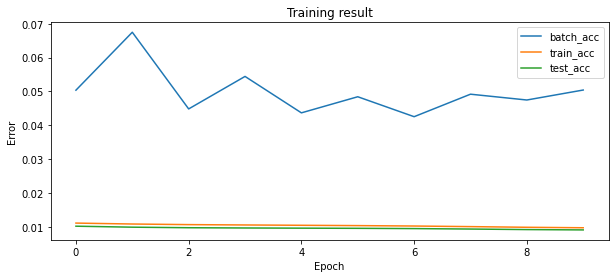

In [16]:
import matplotlib.pyplot as plt
df = pd.DataFrame(data=results, columns = ["epoch", "batch_acc", "train_acc", "test_acc"])
df.set_index("epoch", drop=True, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
 
ax.plot(df)
ax.set(xlabel='Epoch',
       ylabel='Error',
       title='Training result')
 
ax.legend(df.columns, loc=1)

print ("Minimum test loss:", np.min(df["test_acc"]))

In [23]:
sess=tf.Session() 
saver = tf.train.import_meta_graph('model1.ckpt.meta',clear_devices=True)
saver.restore(sess, tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from ./model1.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Graph execution error:

Detected at node 'save/RestoreV2' defined at (most recent call last):
Node: 'save/RestoreV2'
Key Variable_10 not found in checkpoint
	 [[{{node save/RestoreV2}}]]

Original stack trace for 'save/RestoreV2':


In [21]:
graph = tf.get_default_graph()
# X = graph.get_tensor_by_name("X:0")
# y = graph.get_tensor_by_name("y:0")
# y_der = graph.get_tensor_by_name("dydX:0")

#Now, access the op that you want to run. 
# op_to_restore = graph.get_tensor_by_name("prediction:0")
# op_to_restore1 = graph.get_tensor_by_name("gradient:0")

In [22]:
sess.run(prediction,{x:dep_test1})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("X:0", shape=(?, 16), dtype=float32) is not an element of this graph.

In [7]:
writer = tf.summary.FileWriter('./named_scope',sess.graph)
writer.close()